SBI on ODE data, using 100k simulations

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import json

import numpy as np

import re
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch

import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import analysis as analysis

from scipy import signal
from scipy.signal import hilbert
from scipy import stats as spstats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW/SBI'

In [7]:
! mkdir -p results

In [8]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

In [9]:
def Montbrio_SDEmodel(params, constants, I_input, dt, ts, sigma):
   
    delta, eta, J = params[0], params[1], params[2]
    

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init

        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [10]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

In [11]:
t_init = 0.0
t_final = 100.0
dt = 0.001
sigma = 0.0
I0 = 3.
t_on = 30.
t_off = 60.
v0 = -3.0
r0 = 0.5
ts = np.arange(t_init, t_final, dt)
sim_params={'t_init': t_init, 't_final': t_final, 'dt': dt, 'sigma': sigma,
            'I0': I0, 't_on': t_on, 't_off': t_off, 'r0': r0, 'v0': v0}

In [12]:
delta_true = 0.7
eta_true = -4.6
J_true = 14.5
sigma_noise = sigma
params_true = np.array([delta_true, eta_true, J_true])

In [13]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [14]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [15]:
X_obs = np.vstack([v_obs, r_obs])

## Data features

In [16]:
from MPR_NMM_sumstats import calculate_summary_statistics
#args: y, dt, ts, t_on, _off

In [17]:
from scipy import signal
from scipy.signal import  find_peaks, peak_widths
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

In [18]:
calculate_summary_statistics_numba = numba.jit(calculate_summary_statistics)

# Fixed noise 0.1 (v, r)

In [19]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [20]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [21]:
num_sims=100000

In [22]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 142 epochs.------------------------------------------------------------
--- 5781.18253493309 seconds ---


In [23]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [24]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
params_est = np.array(posterior_sample, dtype='float64')

delta_est=params_est[:,0]
eta_est=params_est[:,1]
J_est=params_est[:,2]

params_label=np.array(['$\Delta$', '$\eta$', '$J$'])

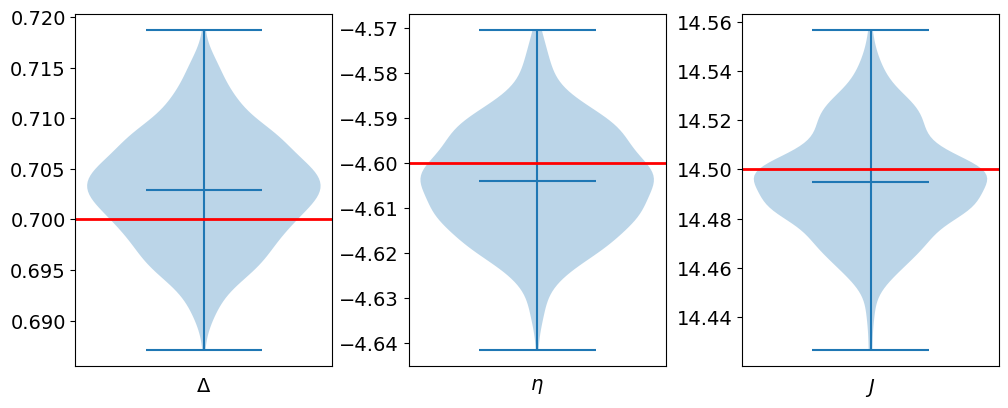

In [26]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=params_true[i], linewidth=2, color='r')
    plt.xticks([])
    plt.yticks(fontsize=14)
    plt.xlabel(params_label[i], fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

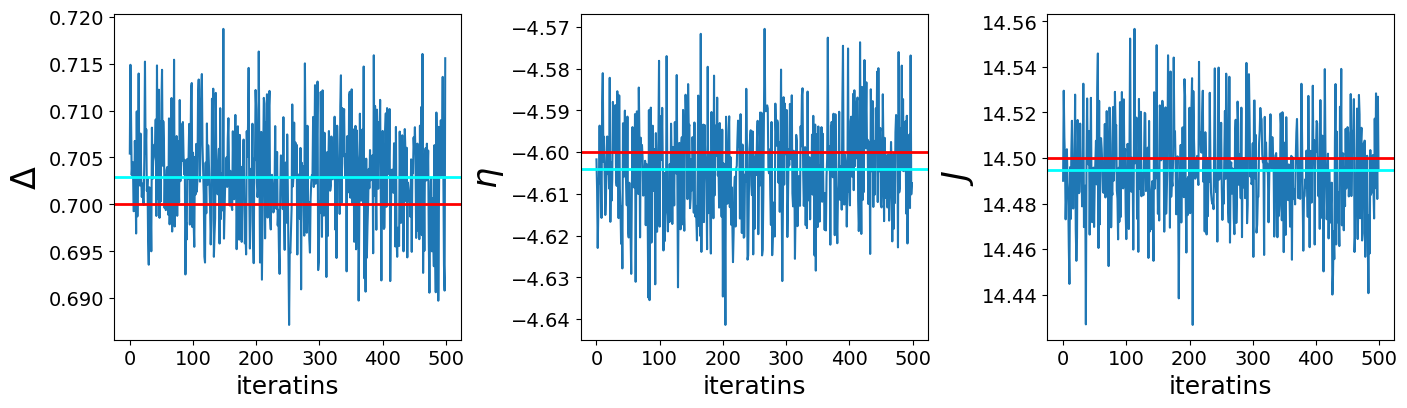

In [27]:
plt.figure(figsize=(14, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.plot(variables)
    plt.axhline(y=params_true[i], linewidth=2, color='r')
    plt.axhline(y=variables.mean(), linewidth=2, color='cyan')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xlabel('iteratins', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [28]:
res_dict = {'delta_distrib': list(delta_est), 'eta_distrib': list(eta_est), 
            'J_distrib': list(J_est)
            }
json_object = json.dumps(res_dict, indent=4)
with open("results_100k/sbi_feat_simODE_output_100k.json", "w") as outfile:
    outfile.write(json_object)

In [29]:
with open("results_100k/sbi_feat_simODE_output_100k.json", "r") as readfile:
    sim = json.load(readfile)

In [30]:
theta_posterior = np.vstack([sim['delta_distrib'], sim['eta_distrib'], sim['J_distrib']]).T

In [31]:
from report_metrics import posterior_peaks
var_labels = ['delta', 'eta', 'J']
MAP = posterior_peaks(torch.as_tensor(theta_posterior), return_dict=True, 
                      labels=var_labels)
params_est = list(MAP.values())
params_est

[0.7032503412694348, -4.60377954950138, 14.495674970198651]

In [32]:
rmse_prms = RMSE(params_true, params_est)
rmse_prms

0.003810319128530128

In [33]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]
y_fit = Montbrio_SDEmodel(np.array(params_est), constants, I_input, dt, ts, sigma)

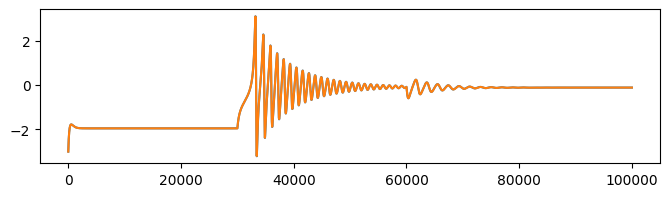

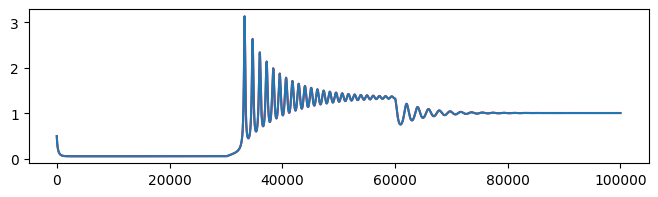

In [34]:
v_sim_est = y_fit[:len(y_fit)//2]
r_sim_est = y_fit[len(y_fit)//2:]

plt.figure(figsize=(8, 2))
plt.plot(v_obs)
plt.plot(v_sim_est)
plt.figure(figsize=(8, 2))
plt.plot(r_obs, 'r')
plt.plot(r_sim_est);

In [35]:
Sim_est = np.vstack([v_sim_est, r_sim_est])
cost = np.sqrt(np.sum((Sim_est - X_obs)**2))

In [36]:
for i in range(len(var_labels)) :
    sim[var_labels[i]] = params_est[i]
sim['rmse_prms'] = rmse_prms
sim['v_sim'] = list(v_sim_est)
sim['r_sim'] = list(r_sim_est)
sim['cost'] = cost

In [37]:
json_object = json.dumps(sim, indent=4)
with open("results_100k/sbi_feat_simODE_output_100k.json", "w") as outfile:
    outfile.write(json_object)